<a href="https://colab.research.google.com/github/Alidine89/microalidine.github.io/blob/main/%F0%9F%8E%AC_Classificateur_vid%C3%A9o_utilisant_LSTM%2BCNN_%7C_UCF50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Commençons 🚀😃

##📦 Bloc 1 : Introduction et importations

In [1]:
##   Project: Action Recognition using CNN + LSTM (UCF50 - 18 classes)
##  Goal: Classify videos based on actions using deep learning (TimeDistributed CNN + LSTM)

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical , plot_model
from tensorflow.keras.optimizers import Adam

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pypiahmad/realistic-action-recognition-ucf50")

print("Path to dataset files:", path)

100%|██████████| 3.04G/3.04G [01:16<00:00, 42.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/pypiahmad/realistic-action-recognition-ucf50/versions/1


##📁 Bloc 2 : Définir les classes et les chemins

In [3]:
# Define the 18 selected action classes
selected_classes = [
    "Basketball",
    "Diving",
    "HorseRace",
    "JumpRope",
    "VolleyballSpiking",
    "WalkingWithDog",
    "BenchPress",
    "Biking",
    "GolfSwing",
    "HighJump",
    "Kayaking",
    "PullUps",
    "PushUps",
    "RopeClimbing",
    "SkateBoarding",
    "SoccerJuggling",
    "Swing",
    "TrampolineJumping"
]

# UCF50 dataset path
#path = "/kaggle/input/realistic-action-recognition-ucf50/UCF50"
path = os.path.join(path, "UCF50") # Correcting the path to the actual dataset directory

# Confirm folder structure
for cls in selected_classes:
    print(f"{cls} → Total videos:", len(os.listdir(os.path.join(path, cls))))

Basketball → Total videos: 137
Diving → Total videos: 153
HorseRace → Total videos: 127
JumpRope → Total videos: 148
VolleyballSpiking → Total videos: 116
WalkingWithDog → Total videos: 123
BenchPress → Total videos: 160
Biking → Total videos: 145
GolfSwing → Total videos: 142
HighJump → Total videos: 123
Kayaking → Total videos: 157
PullUps → Total videos: 120
PushUps → Total videos: 106
RopeClimbing → Total videos: 130
SkateBoarding → Total videos: 120
SoccerJuggling → Total videos: 156
Swing → Total videos: 137
TrampolineJumping → Total videos: 119


##🔍 Bloc 3 : EDA – Montrer des images d’exemple de chaque classe

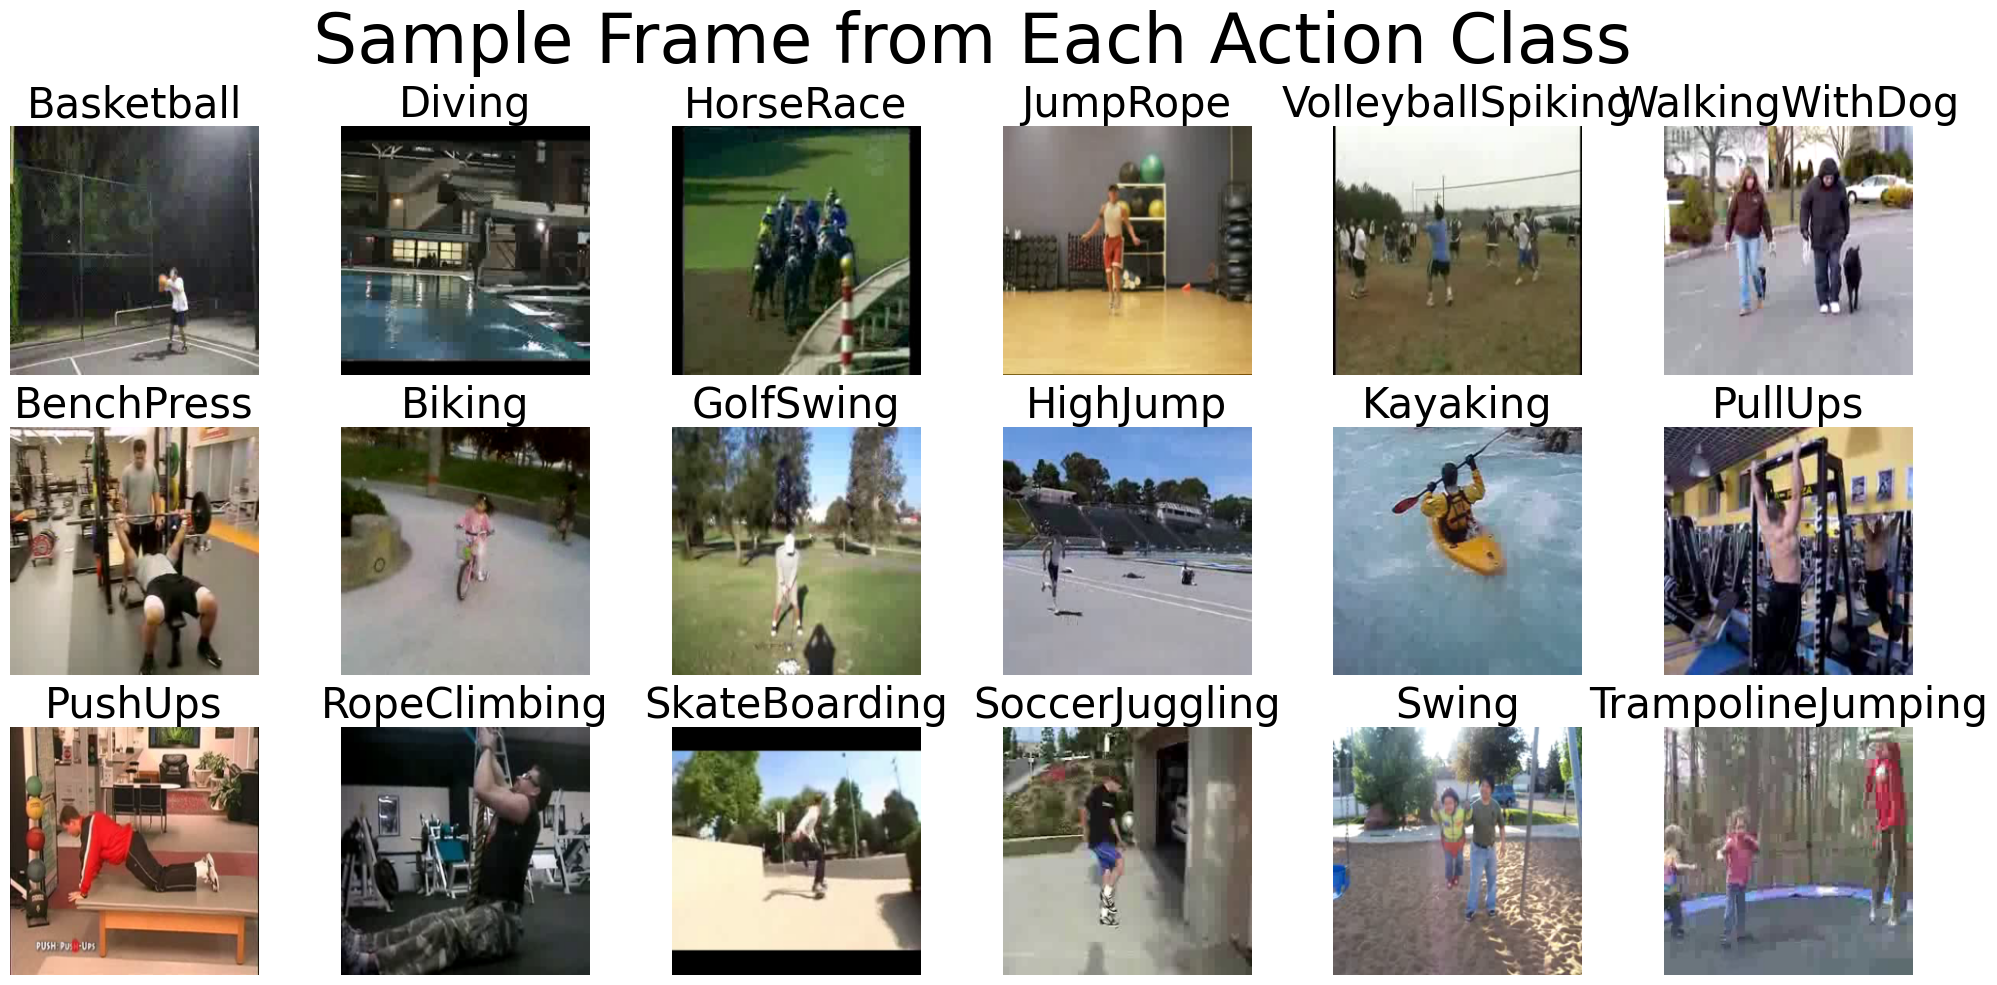

In [4]:
# Show 1 frame from 1 video of each class

def show_sample_frames(classes, path):
    fig, axes = plt.subplots(3, 6, figsize=(20, 10))  # 3 rows and 6 columns
    axes = axes.flatten()  # make it easy to loop over

    for i, cls in enumerate(classes):
        # Load first video from the class folder
        video_path = os.path.join(path, cls, os.listdir(os.path.join(path, cls))[0])
        cap = cv2.VideoCapture(video_path) #think of cap like a video player that's paused and ready to play frame by frame.

        # ret: a boolean (True/False) — it’s True if a frame was read successfully
        # frame: the actual image/frame (as a NumPy array)
        ret, frame = cap.read()
        cap.release() # This closes the video file after you're done

        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, (256, 256))
            axes[i].imshow(frame)
            axes[i].set_title(cls , fontsize = 30)
        axes[i].axis('off')

    plt.suptitle(" Sample Frame from Each Action Class", fontsize=50)
    plt.tight_layout()
    plt.show()

# Calling
show_sample_frames(selected_classes, path)

##🎞️ Bloc 4 : Extraction des images des vidéos

In [5]:
#  Extract fixed number of frames from each video
# For simplicity and speed, we’ll extract 20 frames per video

def extract_frames(video_path, num_frames=20):
    frames = []
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_interval = max(total_frames // num_frames, 1)

    count = 0
    while len(frames) < num_frames and cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if count % frame_interval == 0:
            frame = cv2.resize(frame, (64, 64))
            frame = frame / 255.0  # Normalize pixel values
            frames.append(frame)
        count += 1
    cap.release()

    # Pad with last frame if video too short
    while len(frames) < num_frames:
        frames.append(frames[-1])

    return np.array(frames)

##🧠 Bloc 5 : Charger des vidéos et créer un jeu de données

In [6]:
# Loop through videos in selected classes and extract frames
X = []
y = []

for class_index, cls in enumerate(selected_classes):
    class_path = os.path.join(path, cls)
    videos = os.listdir(class_path)

    for video in videos:
        video_path = os.path.join(class_path, video)
        frames = extract_frames(video_path, num_frames=20)
        if frames.shape == (20, 64, 64, 3):  # Ensure consistent shape
            X.append(frames)
            y.append(class_index)

X = np.array(X)
y = to_categorical(y) # One-Hot

print(" Data Loaded:")
print("X shape:", X.shape)  # (samples, time_steps, height, width, channels)
print("y shape:", y.shape)  # (samples, num_classes)

 Data Loaded:
X shape: (2419, 20, 64, 64, 3)
y shape: (2419, 18)


##✂️ Bloc 6 : Séparation train-essai


In [7]:
#  Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training videos:", X_train.shape[0])
print("Testing videos:", X_test.shape[0])

Training videos: 1935
Testing videos: 484


##🏗️ Bloc 7 : Construire le modèle CNN + LSTM avec TimeDistributed

In [8]:
#  Model = CNN applied on each frame using TimeDistributed + LSTM for sequence learning

model = Sequential()
model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=(20, 64, 64, 3)))
model.add(TimeDistributed(MaxPooling2D(2,2)))
model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D(2,2)))
model.add(TimeDistributed(Flatten()))

# LSTM layer for temporal patterns
model.add(LSTM(64))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(18, activation='softmax'))  # 18 classes

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])


#CNNs process one image at a time.

#TimeDistributed allows us to apply the same CNN to each frame in a video — one by one — automatically.

# CNNs: Take each frame of video and say "Ah! I see a net, a ball, a hand…"

# LSTM: Looks at how these elements move across frames and says "This looks like basketball!"

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


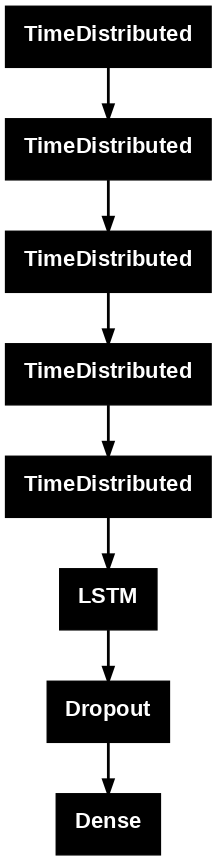

In [9]:
plot_model(model,dpi=100)

##🏃 ♂️ Bloc 8 : Entraîner le modèle

In [ ]:
#  Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=4)

Epoch 1/10                      

I0000 00:00:1751270592.961100    9845 cuda_dnn.cc:529] Loaded cuDNN version 90300

484/484 ━━━━━━━━━━━━━━━━━━━━ 26s 32ms/step - accuracy: 0.0865 - loss: 2.9262 - val_accuracy: 0.2417 - val_loss: 2.6739                    
Epoch 2/10                      
484/484 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.2059 - loss: 2.6003 - val_accuracy: 0.4050 - val_loss: 2.0582                
Epoch 3/10                  
484/484 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.4144 - loss: 1.9764 - val_accuracy: 0.5186 - val_loss: 1.8537                
Epoch 4/10                      
484/484 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.5204 - loss: 1.6321 - val_accuracy: 0.6198 - val_loss: 1.4137                
Epoch 5/10                      
484/484 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6230 - loss: 1.3607 - val_accuracy: 0.6860 - val_loss: 1.2542                
Epoch 6/10                      
484/484 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.6899 - loss: 1.1222 - val_accuracy: 0.7252 - val_loss: 0.9955                
Epoch 7/10                      
484/484 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.7799 - loss: 0.8478 - val_accuracy: 0.7314 - val_loss: 0.9681                
Epoch 8/10                      
484/484 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.8227 - loss: 0.6848 - val_accuracy: 0.7707 - val_loss: 0.8495                
Epoch 9/10                      
484/484 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.8539 - loss: 0.5848 - val_accuracy: 0.7748 - val_loss: 0.7571                
Epoch 10/10                     
484/484 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.9113 - loss: 0.4171 - val_accuracy: 0.7872 - val_loss: 0.6941

##📊 Bloc 9 : Précision et perte du graphique

In [ ]:
#  Training vs Validation Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

#  Training vs Validation Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

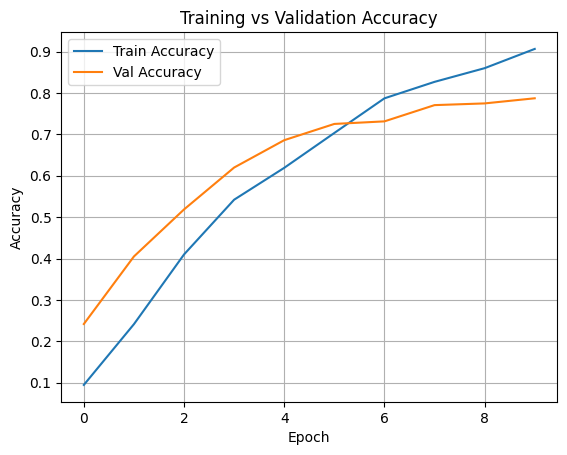   
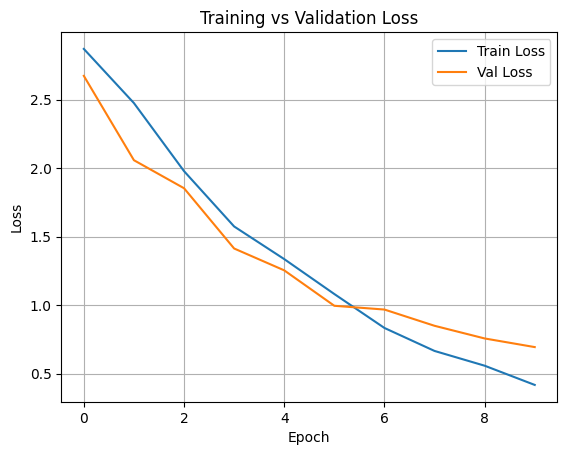

##🎥 Bloc 10 : Montrer les prédictions du modèle sur 5 vidéos de tests aléatoires

In [ ]:
#  Visualize model predictions on 5 test videos (larger images)
def show_predictions(model, X_test, y_test, class_names):
    # Get 5 random indices
    indices = np.random.choice(len(X_test), 5, replace=False)

    # Bigger canvas size
    fig, axes = plt.subplots(1, 5, figsize=(25, 8))  #  Wider and taller

    for i, idx in enumerate(indices):
        video = X_test[idx]
        true_label = class_names[np.argmax(y_test[idx])]

        # Predict
        prediction = model.predict(np.expand_dims(video, axis=0), verbose=0)
        predicted_label = class_names[np.argmax(prediction)]

        # Get middle frame and denormalize
        mid_frame = video[len(video) // 2]
        mid_frame = (mid_frame * 255).astype(np.uint8)

        # Optional: remove resizing if frame is already big enough
        # frame = cv2.resize(mid_frame, (256, 256))  # or skip this
        frame = mid_frame  # Show full original frame size

        # Plot
        axes[i].imshow(frame)
        axes[i].set_title(f"True: {true_label}\nPred: {predicted_label}", fontsize=30)
        axes[i].axis('off')

    plt.suptitle(" Model Predictions on Test Videos", fontsize=30)
    plt.tight_layout()
    plt.show()

#  Run it
show_predictions(model, X_test, y_test, selected_classes)

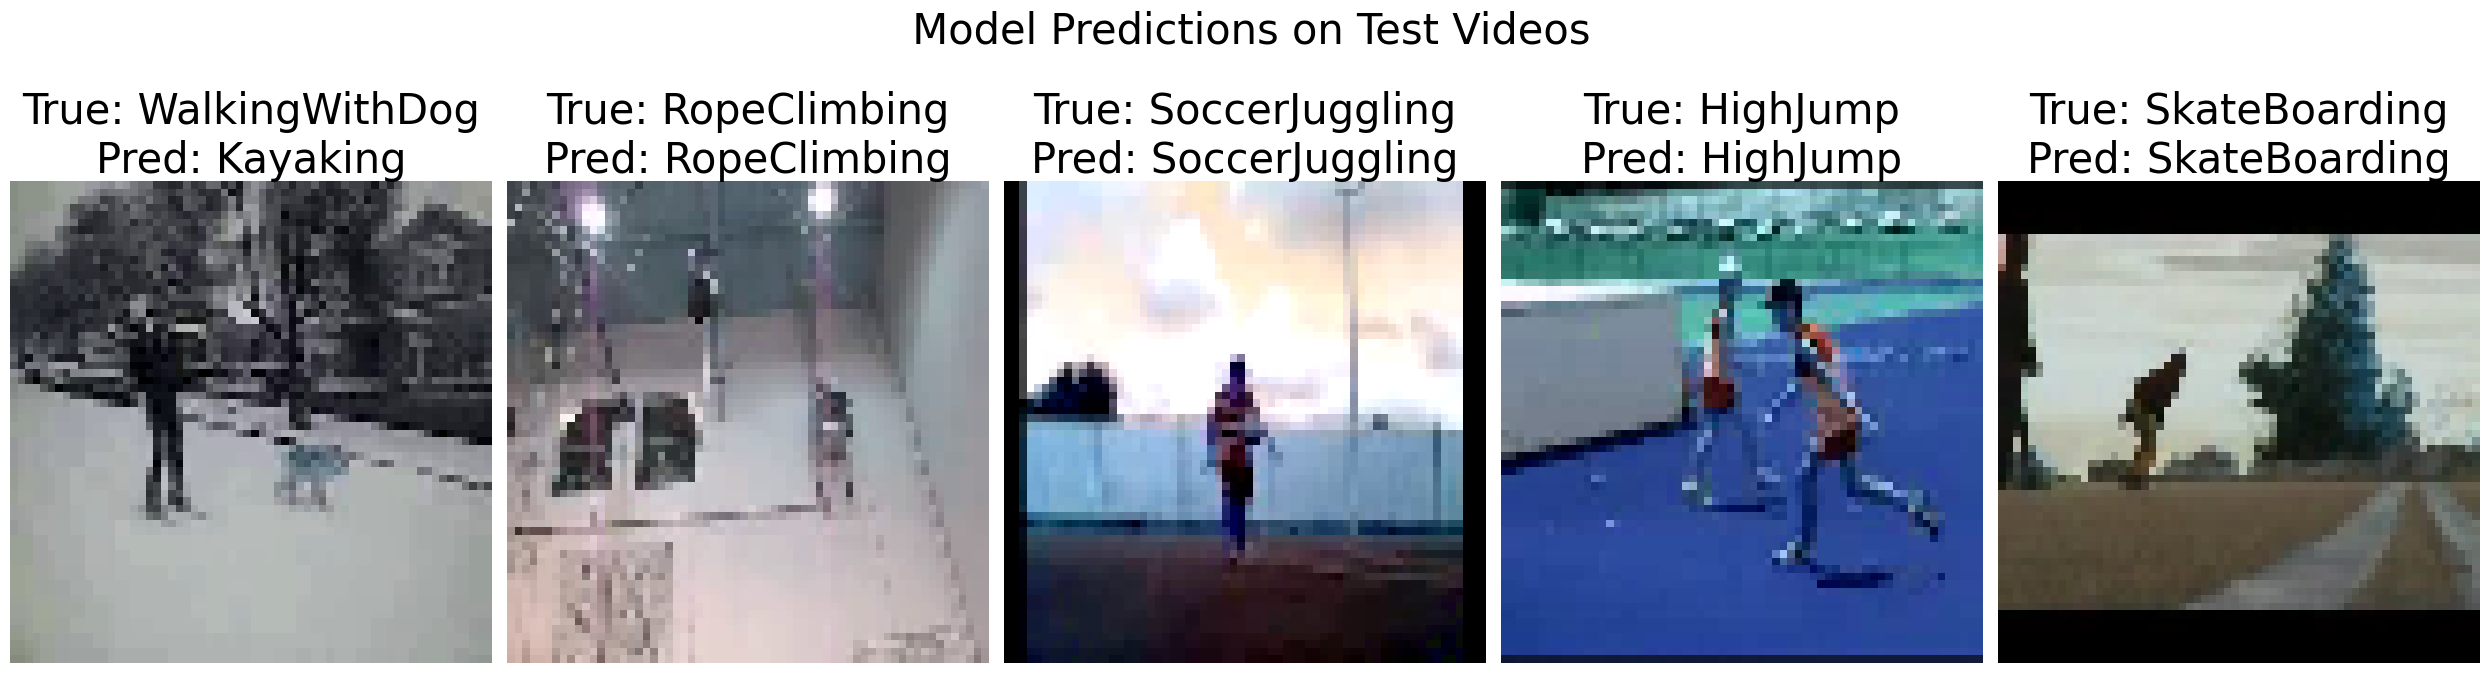

##🎉 Bloc 11 : Notes finales pour les apprenants

In [ ]:
#  Summary for Learners:
print("1- We built an action recognition model using CNN + LSTM (TimeDistributed)")
print("2- CNN: Extracted spatial features from each frame")
print("3- LSTM: Learned sequence of actions over time")
print("4- Only 18 classes used to keep it simple")

print("****"*4)
print("You can improve it by:")
print("1- Using more video samples")
print("2- Using data augmentation or 3D CNNs")
print("3- Trying all 50 classes in UCF50")

1- We built an action recognition model using CNN + LSTM(TimeDistributed)          
2- CNN: Extracted spatial features from each frame        
3- LSTM: Learned sequence of actions over time              
4- Only 18 classes used to keep it simple
****************
You can improve it by:          
1- Using more video samples     
2- Using data augmentation or 3D CNNs                         
3- Trying all 50 classes in UCF50

#Smash That Upvote !! Thanks ! 🚀😃